# Introduction

The applications of brain tumour classification can be mainly divided into two categories:
- Classification of brain images into normal and abnormal classes, i.e. whether the brain images contain tumours or not.
- Classification within abnormal brain images, in other words, discrimination between different types of brain tumours.

We are in the first case here, which is a binary classification (normal and abnormal). The important of this study is also contain by the fact of conventional diagnoses of brain tumor images are made by human interpretation, which heavily relies on the experience of radiologists who review and analyze the characteristics of the images. Consequently, interobserver and intraobserver variability are inevitable. That's why computer-aided diagnosis system can be very interesting to reduce the number of errors and help the diagnostic decision.

This brain tumor dataset containing 253 images with two possibilities: normal MRI (no tumor), or abnormal MRI (tumor). The original data can be found following this link: [kaggle-brain-mri-images](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

The objective of this project is to build a classifier to classify each type of tumor. To do so, we will train a CNN using transfer learning, and to speed up training, we will use Tensorflow graph mode.

In [1]:
# Imports
import random
import zipfile
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16

First of all, we can initialize some constants, such as the image shape, the batch size, the split size (for train, validation and test sets) or the number of epochs.

In [2]:
# Constants
DATA_PATH = "./data/kaggle/"

IMAGE_SHAPE = (256, 256)

LABELS_NAME = {
    0 : "No tumor",
    1 : "Tumor"
}

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 512

SPLIT_SIZE = 0.7

EPOCHS = 20

Now we define some functions, to plot images with the labels (normal or abnormal MRI) or with the model predictions, but also to preprocess the data and train the model.

We decorate some function with the `tf.function` to enable autograh, which swith from eager mode to graph mode, resulting in an acceleration of training time. To do this, we define function to create a custom training loop, which handles gradients differentiation, loss and metrics calculation.

Note that the notebook was run on Google Colab using a GPU, to speed up the training.

In [3]:
def show_image(images: np.ndarray, labels: np.ndarray, names: dict=LABELS_NAME) -> None:
    """Take the a random image and plot it, with as title the class label of the image.

    Args:
        images (ndarray): The images stored in an array.
        labels (ndarray): The labels stored in an array.
        names (dict): A dictionary used to convert the label into a meaningful word.
            Defaults to LABELS_NAME.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()

def predict_image(images: np.ndarray, labels: np.ndarray, prediction: np.ndarray) -> None:
    """Take the a random image and plot it, with as title the predicted value
    of the image.

    Args:
        images (ndarray): The images stored in an array.
        labels (ndarray): The labels stored in an array.
        prediction (ndarray): The model predictions stored in an array.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

# Decorate this function to enable autograph on the data preprocessing
@tf.function
def map_image(image: np.ndarray, label: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Cast image type to float32 and normalize it. Note that the function is decorated to enable
    graph mode in Tensorflow.

    Args:
        image (ndarray): The array of images.
        label (ndarray): The array of labels

    Returns:
        ndarray: The array of images casted and normalized.
        ndarray: The unchanged array of labels.
    """
    image = tf.cast(image, dtype=tf.float16)
    image = image / 255.0
    image = tf.image.grayscale_to_rgb(image)

    return image, label

def train_one_step(
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Adam,
    x: tf.Tensor,
    y: tf.Tensor,
    train_loss: tf.keras.losses.SparseCategoricalCrossentropy,
    train_accuracy: tf.keras.metrics.SparseCategoricalAccuracy
) -> tf.keras.losses.SparseCategoricalCrossentropy:
    """Trains on a batch of images for one step.

    Args:
        model (Model): CNN classifier.
        optimizer (Adam): optimizer to use during training.
        x (Tensor): training images.
        y (Tensor): training labels.
        train_loss (Loss): loss object for training.
        train_accuracy (Metric): accuracy metric for training.

    Returns:
        SparseCategoricalCrossentropy : loss object calculated during training.
    """
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss
        loss = train_loss(y_true=y, y_pred=predictions)

    # Compute the gradients on model variables
    grads = tape.gradient(loss, model.trainable_weights)

    # Apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)

    return loss

# Decorate this function to enable autograph on the training loop
@tf.function
def train(
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Adam,
    epochs: int,
    device: str,
    train_ds: tf.data.Dataset,
    train_loss: tf.keras.losses.BinaryCrossentropy,
    train_accuracy: tf.keras.metrics.BinaryAccuracy,
    valid_ds: tf.data.Dataset,
    val_loss: tf.keras.losses.BinaryCrossentropy,
    val_accuracy: tf.keras.metrics.BinaryAccuracy
) -> dict:
    """Performs the entire training loop. Prints the loss and accuracy per step and epoch. Note
    that the function is decorated to enable graph mode in Tensorflow.

    Args:
        model (Model): CNN classifier.
        optimizer (Adam): optimizer to use during training.
        epochs (int): number of epochs.
        train_ds (Dataset): the train set containing image-label pairs.
        train_loss (Loss): loss function for training.
        train_accuracy (Metric): accuracy metric for training.
        valid_ds (Dataset): the val set containing image-label pairs.
        val_loss (Loss): loss function for validation.
        val_accuracy (Metric): accuracy metric for validation.

    Returns:
        dict: training history saved into a dictionary.
    """
    loss = 0.0
    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': []
    }

    for epoch in range(epochs):
        for x, y in train_ds:
            # Training step number increments at each iteration
            with tf.device(device_name=device):
                # Run one training step
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

        # Print the training step number, loss and accuracy
        tf.print('EPOCH:', epoch)
        tf.print('train loss:', loss, '- train accuracy:', train_accuracy.result())

        # Save train loss and accuracy
        history['train_acc'].append(train_accuracy.result())
        history['train_loss'].append(loss)

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss:', loss, '- val accuracy:', val_accuracy.result())

        # Save train loss and accuracy
        history['val_acc'].append(val_accuracy.result())
        history['val_loss'].append(loss)

    return history

## Data loading

In this section, we load the data into Numpy arrays for convenience. We first unzip the data, store the result into lists, and then convert lists into Numpy arrays with a particular attention of the data shape.

In [4]:
# Define lists to store images and labels
image_list, label_list = [[] for _ in range(2)]

# Read the zip file
with zipfile.ZipFile(os.path.join(DATA_PATH, 'BrainTumorData.zip'), 'r') as zip_ref:
    # Get the list of files
    files = zip_ref.namelist()

    for file in files:
        # Load the image
        with zip_ref.open(file) as bytes:
            image_list.append(tf.keras.preprocessing.image.load_img(
                BytesIO(bytes.read()),
                color_mode='grayscale',
                target_size=IMAGE_SHAPE
            ))
        # Get the label
        label_list.append(int(file.split('/')[0] == "yes"))

assert len(image_list) == len(label_list)

In [5]:
# Concatenate the list of images into a single numpy array
images = np.expand_dims(np.stack(image_list), axis=3)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (253, 256, 256, 1)
Label shape: (253,)


## Exploratory Data Analysis

We can start by ploting a random image from the dataset. Note that tumors are easy to spot in this dataset.

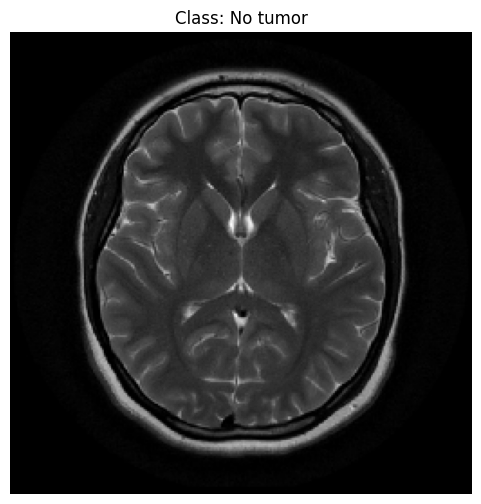

In [6]:
# Plot an image
show_image(images, labels)

Now we can dislay the target repartition to see if we have an imbalanced dataset.

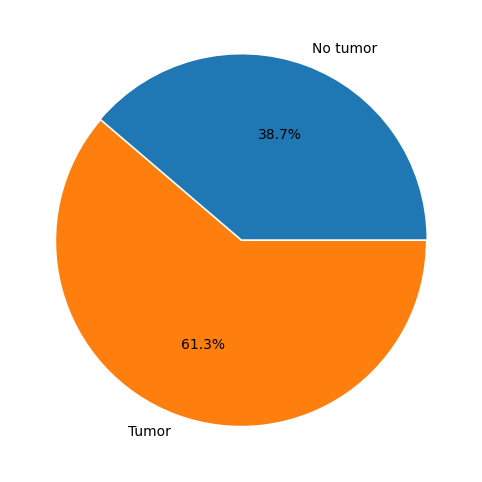

In [7]:
# Repartition of the classes across the dataset
_, counts = np.unique(labels, return_counts=True)

# Plot classes counts
plt.figure(figsize=(9, 6))
plt.pie(
    counts,
    labels=["No tumor", "Tumor"],
    autopct="%1.1f%%",
    explode=(0.01, 0)
)
plt.show()

We can see that we have a majority of tumour images in the dataset, but the imbalance is not critical, so we can continue without applying undersampling or oversampling methods.

## Preprocessing

In this section we split the dataset into a train, validation and test set, using the split size constant defined earlier.

In [8]:
# Split train data
X_train, X_tmp, y_train, y_tmp = train_test_split(
    images,
    labels,
    shuffle=True,
    stratify=labels,
    train_size=SPLIT_SIZE,
    random_state=42
)

# Split validation and test data
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,
    y_tmp,
    shuffle=True,
    stratify=y_tmp,
    train_size=SPLIT_SIZE,
    random_state=42
)

Then, we convert the Numpy arrays into Tensorflow datasets in order to preprocess the data using the function defined above, shuffle, batch and prefetch it (shuffle and prefetch are only applied to the train dataset).

Remember that the `map_image` use graph mode to speed up the preprocessing.

In [9]:
# Load the datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(map_image).shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE).prefetch(1)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(map_image).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(map_image).batch(BATCH_SIZE)

## Modeling

As we said earlier, we're going to train the CNN and use transfer learning to improve your performance. We have chosen the VGG16 algorithm. This is a deep convolutional neural network, but simple enough to match your dataset with just a few images. 

Note that we exclude the top part of the network since we are only interested in the model weights. And we freeze the pre-trained layers to avoid destroying the weights during training. (We can unfreeze them after a few epochs, when the model gradients decrease).

In [10]:
# Load VGG16 model
pre_trained_model = VGG16(
    input_shape=IMAGE_SHAPE + (3, ),
    include_top=False
)

# Freez ResNet50 layers
for layer in pre_trained_model.layers:
    layer.trainable = False

We add to the pre-trained layers, the top of your network. First we add (trainable) convolutional layers, then we add dense layers to predict output probabilities using the sigmoid activation fuction.

Note that we use the Functional API of Tensorflow.

In [11]:
# Model definition
last_output = pre_trained_model.output

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(last_output)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

As you can see there is a total of 14,801,777 parameters in the model, but only 87,089 are trainable because we freeze the weights of the pre-trained model.

We can define the optimizer, loss and metrics that will be used during training. Since we are in a binary classification (normal vs abnormal), we use the binary cross-entropy, and binary accuracy (the imbalance is not too critical, so accuracy is still a good metric).

We use an Adam optimize with an exponential learning rate decay. It will decrease the learning rate as the training progress.

In [12]:
# Define optimizer with exponential decay
decay_steps = EPOCHS * len(X_train) // BATCH_SIZE
lr = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps, 0.1)
optimizer = tf.keras.optimizers.Adam(lr)

# Define losses
train_loss = tf.keras.losses.BinaryCrossentropy()
val_loss = tf.keras.losses.BinaryCrossentropy()

# Define metrics
train_accuracy = tf.keras.metrics.BinaryAccuracy()
val_accuracy = tf.keras.metrics.BinaryAccuracy()

In [13]:
# Check if a GPU is available (for example on Google Colab)
# Otherwise use a CPU (much slower)
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
print(device)

/gpu:0


Then we train the model using the defined function. Note that this function use the Tensorflow graph mode to speed up the training.

In [14]:
# Model training
history = train(
    model,
    optimizer,
    EPOCHS,
    device,
    train_ds,
    train_loss,
    train_accuracy,
    val_ds,
    val_loss,
    val_accuracy
)

EPOCH: 0
train loss: 0.621010661 - train accuracy: 0.531073451
val loss: 0.641316831 - val accuracy: 0.622641504
EPOCH: 1
train loss: 0.58623594 - train accuracy: 0.57062149
val loss: 0.608959258 - val accuracy: 0.622641504
EPOCH: 2
train loss: 0.615024626 - train accuracy: 0.583804131
val loss: 0.572081447 - val accuracy: 0.622641504
EPOCH: 3
train loss: 0.456305951 - train accuracy: 0.591807902
val loss: 0.520237327 - val accuracy: 0.632075489
EPOCH: 4
train loss: 0.47758019 - train accuracy: 0.631638408
val loss: 0.454274327 - val accuracy: 0.645283043
EPOCH: 5
train loss: 0.442584455 - train accuracy: 0.661016941
val loss: 0.39415586 - val accuracy: 0.672956
EPOCH: 6
train loss: 0.725644648 - train accuracy: 0.693301
val loss: 0.321102083 - val accuracy: 0.69272238
EPOCH: 7
train loss: 0.260870397 - train accuracy: 0.718926549
val loss: 0.31103158 - val accuracy: 0.709905684
EPOCH: 8
train loss: 0.293781102 - train accuracy: 0.736346543
val loss: 0.277646 - val accuracy: 0.721174
E

Once the training has been completed, we can trace the loss and accuracy of the training and validation.

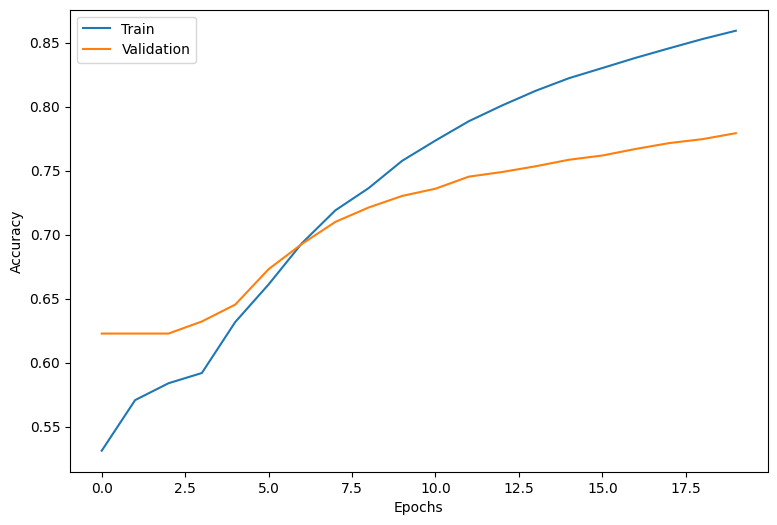

In [20]:
plt.figure(figsize=(9, 6))
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see that we get good accuracy on both the training and validation sets, but if we train for more epochs, we risk overfitting.

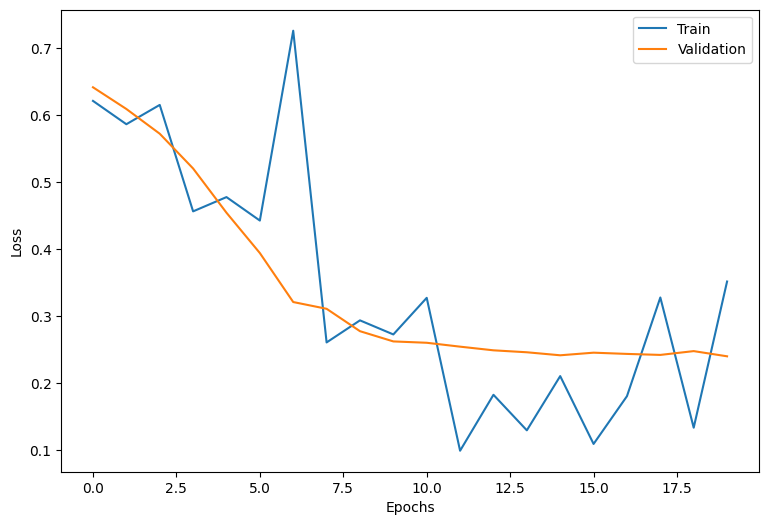

In [21]:
plt.figure(figsize=(9, 6))
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The losses follow roughly the same direction, but we can see that the variations in training loss are significant, which may be due to the small number of images and an excessively large batch size.

The result seems good, so we can try to predict labels on the test set and display the accuracy.

In [22]:
# Make predictions
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model.predict(images)
        preds = np.where(preds > .5, 1, 0).reshape(-1)

print(
    f"Model accuracy: {accuracy_score(y_test, preds) * 100:.2f}%"
)

1/1 [==============================] - 0s 53ms/step
Model accuracy: 86.96%


It is good result, especially with so few images, we can display a confusion matrix on the test set predictions, to have a better understanding of this metric.

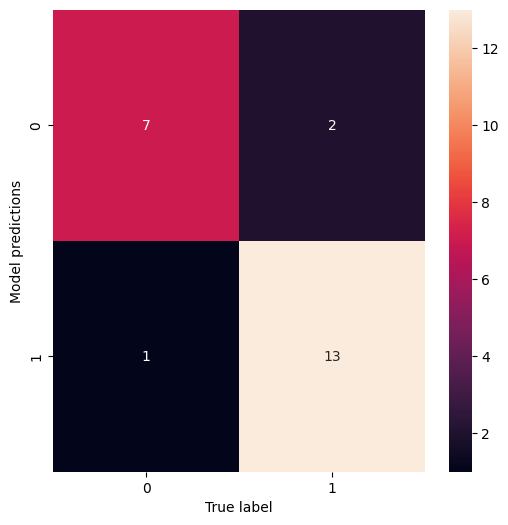

In [23]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)
plt.xlabel("True label")
plt.ylabel("Model predictions")
plt.show()

The class imbalance may have an effect on the model prediction, one way to improve our result is to use weight on the classes to penalize more error on the class 0 (No tumor).

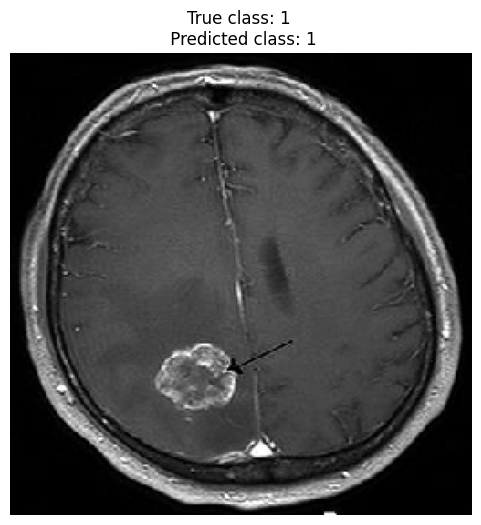

In [24]:
predict_image(X_test, y_test, preds)

In this case, we can see that the model prediction is right.

## Conclusion

Although we had few images, we were able to build a relatively good model, using CNN and transfer learning. We accelerated the training of the model using Tensorflow's graphical mode by defining a custom training loop.

We get good results, but we can still improve our model, for example by trying another pre-trained model, or by unfreezing the weights of the pre-trained model to allow fine tuning and avoid overfitting when training with more epochs. Of course, gathering more data can also contribute greatly to improving the model's performance.